# Project Review 2 
## Exploration of Correlation between spike in releases and new vulnerabilities
### Gabriel Wilmoth
#### Basic Library Imports (Run First)

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import datetime as dt
import glob
import statistics as stat
from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from scipy.optimize import curve_fit
from scipy.special import factorial
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [16,9]

### Reading in Release CSV

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
# Path to release.csv, and whether to select uncompressed or ocmpressed version
# release_path = 'D:/data/open_source/release.csv'
release_path = 'C:\\Users\\Faugh\\Desktop\\DataScienceData\\popular-3k-python\\release.csv'

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

In [5]:
release_df.head()

,id,date,name,comment,author
0,\xae671a0067dbeabbc3cb546705edc1f81f71a193,2015-02-03 21:58:44,\x72656c656173652d323031352d30322d3034,"Release for February 4th, 2015\n",91949
1,\x33e2c27d1ec224a54ed7ca4a6e09c352e92a227d,2013-07-05 04:58:14,\x76302e32392e31,tag version 0.29.1\n,140982
2,\x1f9bcd823807f41afaab6b74b34473531ca7eb30,2013-03-29 13:02:20,\x76332e302e30,What's new in Tornado 3.0\n===================...,207066
3,\x3206fb28a040494bac6973310e7f21f031989da6,2010-12-09 04:14:19,\x6275696c642d343639,Windows build SickBeard-win32-alpha-build469\n,875380
4,\x652fc27cf9fe9262d2c941d6385043efa41016da,2011-11-08 01:22:48,\x312e312e36,Fabric 1.1.6\n,63770


### Reading in NVD CSV's

In [6]:
def import_nvd():
    path = '../../DataScienceData/NVDDataset/'
    all_nvds = glob.glob(path+'*.json')
    l = []
    
    for filename in all_nvds:
        nvd_df = pd.read_json(filename)
        nvd_df = clean_nvd(nvd_df)
        l.append(nvd_df)
    
    return pd.concat(l, ignore_index=True)

def clean_nvd(df):
    df = json_normalize(df['CVE_Items'])
    df = df[['cve.CVE_data_meta.ID', 'publishedDate', 'impact.baseMetricV2.cvssV2.baseScore']]
    df.columns = ['cve_id', 'published_date', 'base_score']
    df['published_date'] = df['published_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%MZ'))
    df = df[(df['published_date'] >= '2005-07-07') & (df['published_date'] < '2018-10-01')]
    
    return df

In [7]:
vulns = import_nvd()
print(vulns.head())

          cve_id      published_date  base_score
0  CVE-1999-1593 2009-01-15 01:30:00         7.6
1  CVE-2000-1245 2010-04-05 15:30:00         7.5
2  CVE-2000-1246 2010-04-05 15:30:00         3.5
3  CVE-2000-1247 2011-10-05 02:56:00         2.1
4  CVE-2000-1254 2016-05-05 01:59:00         5.0


In [8]:
vulns.head(20)

,cve_id,published_date,base_score
0,CVE-1999-1593,2009-01-15 01:30:00,7.6
1,CVE-2000-1245,2010-04-05 15:30:00,7.5
2,CVE-2000-1246,2010-04-05 15:30:00,3.5
3,CVE-2000-1247,2011-10-05 02:56:00,2.1
4,CVE-2000-1254,2016-05-05 01:59:00,5.0
5,CVE-2001-0654,2017-05-11 14:29:00,NaN
6,CVE-2001-0655,2017-05-11 14:29:00,NaN
7,CVE-2001-0656,2017-05-11 14:29:00,NaN
8,CVE-2001-0657,2017-05-11 14:29:00,NaN
9,CVE-2001-0798,2017-05-11 14:29:00,NaN


### Measure of Vulnerabilities Per Week

In [9]:
vulnsWeekCount = pd.DataFrame()
vulnsWeekCount['count'] = vulns['published_date'].value_counts().resample('w').apply('count')
vulnsWeekCount.head()

,count
2005-07-10,3
2005-07-17,4
2005-07-24,3
2005-07-31,3
2005-08-07,6


#### -Plotting of New Vulnerabilities by Week

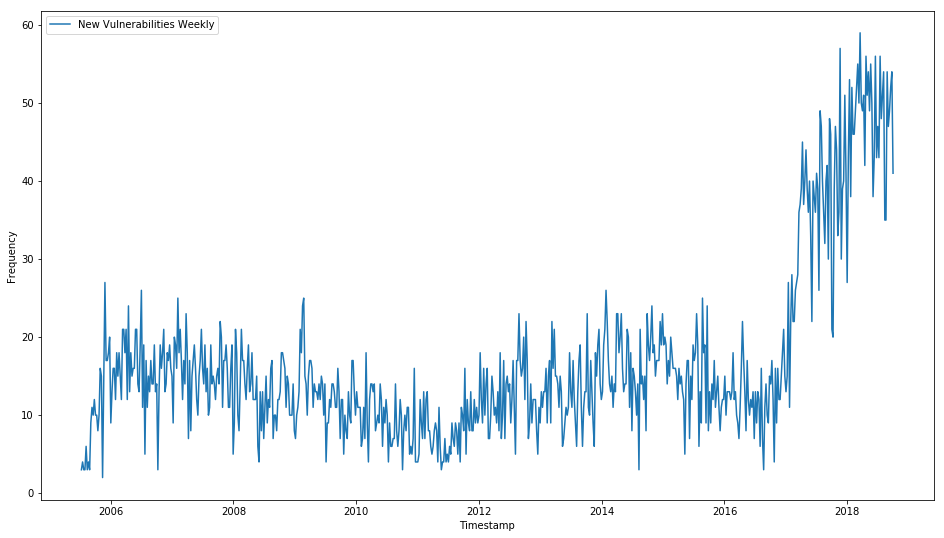

In [12]:
#vulnsWeekCount.plot()
plt.plot(vulnsWeekCount, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Basic Statistics on New Vulnerabilties (Weekly)
       - Mean: 16.60781476121563
       - Median: 14.0
       - Variance: 125.13727217433251
       - Standard Deviation: 11.186477201261017

In [13]:
vulnsWeekCount_mean = vulnsWeekCount['count'].mean()
vulnsWeekCount_med = vulnsWeekCount['count'].median()
print( vulnsWeekCount_mean )
print( vulnsWeekCount_med )
vulnsWeekCount_variance = stat.variance(vulnsWeekCount['count'], vulnsWeekCount_mean)
print(vulnsWeekCount_variance)
vulnsWeekCount_stdev = stat.stdev(vulnsWeekCount['count'])
print(vulnsWeekCount_stdev)

16.60781476121563
14.0
125.13727217433251
11.186477201261017


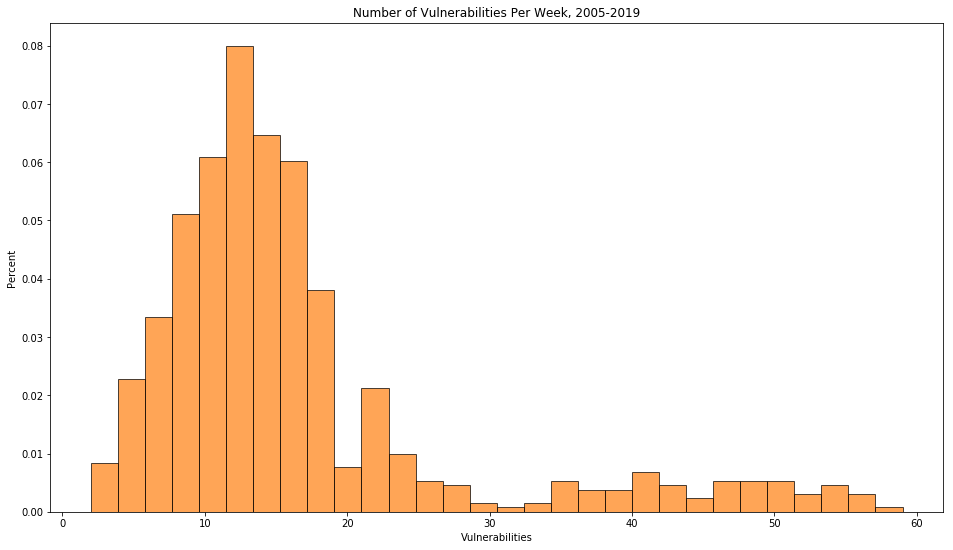

In [14]:
plt.hist(vulnsWeekCount['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")

plt.xlabel('Vulnerabilities')
plt.ylabel('Percent')
plt.title('Number of Vulnerabilities Per Week, 2005-2019')
plt.show()

#### -Fitting Distribution to a Model

In [15]:
mu,std = norm.fit(vulnsWeekCount['count'])

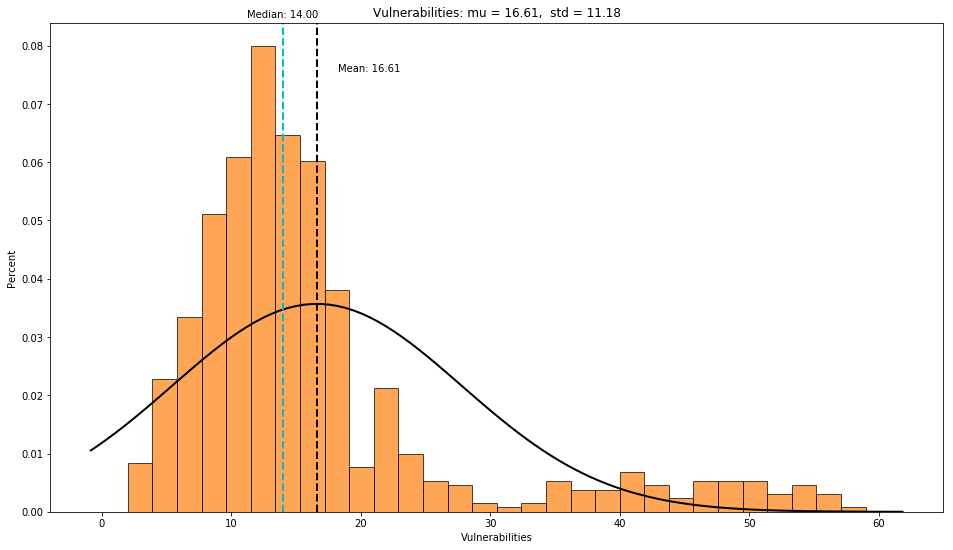

In [16]:
plt.hist(vulnsWeekCount['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Vulnerabilities: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Vulnerabilities')
plt.ylabel('Percent')

#Calc Mean and Display
plt.axvline(vulnsWeekCount['count'].mean(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(vulnsWeekCount['count'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(vulnsWeekCount['count'].mean()))

#Calc Median and Display
plt.axvline(vulnsWeekCount['count'].median(), color='c', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(vulnsWeekCount['count'].median()*.8, max_ylim*1.01, 'Median: {:.2f}'.format(vulnsWeekCount['count'].median()))

plt.show()

#### -Model Observations
    - The data is skewed right thus, a normal distribution does not represent the data at the current state. 
#### -Normalizing the Data
    - Taking the Square Root of our dataFrame vulnsWeekCount to hopefully provide a more normal distribution.
        - Taking the Square Root can help to transform skewed data into a more normally distributed model

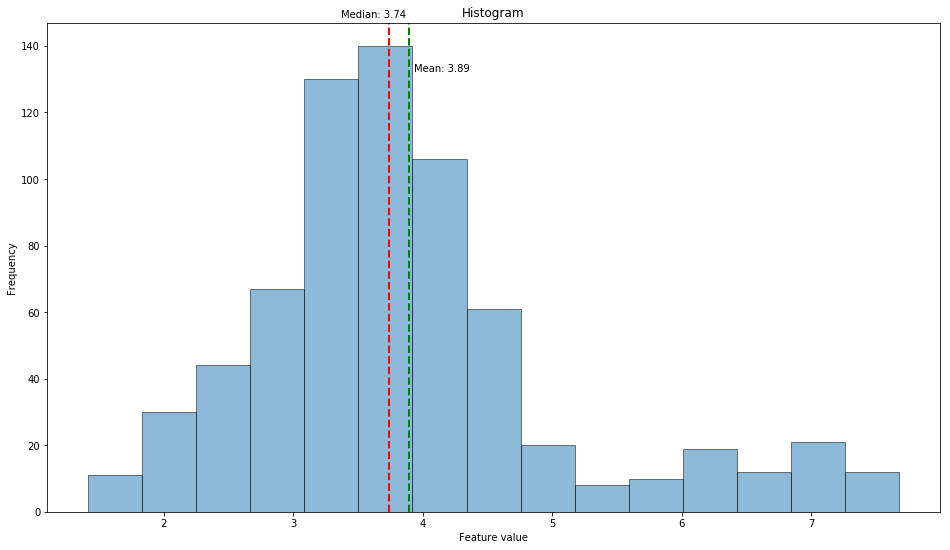

In [17]:
df_pow = vulnsWeekCount.apply(np.sqrt)
df_pow.plot.hist(alpha=0.5, bins=15, color = "C0", legend=None, ec="black", linestyle='solid')
plt.xlabel("Feature value")
plt.title("Histogram")

#Calc Mean and Display
plt.axvline(df_pow['count'].mean(), color='g', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].mean()*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pow['count'].mean()))

#Calc Median and Display
plt.axvline(df_pow['count'].median(), color='r', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].median()*.9, max_ylim*1.01, 'Median: {:.2f}'.format(df_pow['count'].median()))

plt.show()

#### -Normalizing the Data Cont...
    - Looks like the above histogram almost resembles a normal curve.
    - Below we spread out the number of points between min and max and fit a Bell Curve to the data.

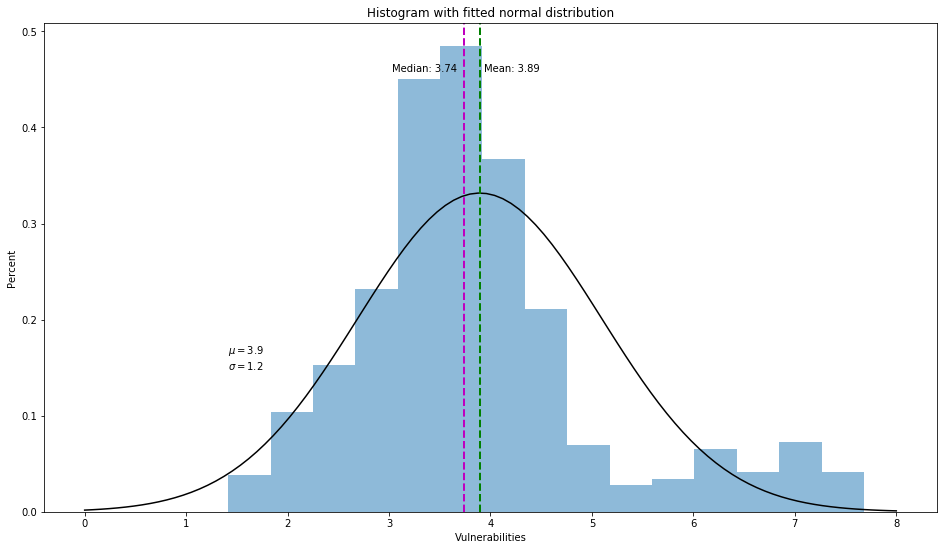

In [18]:
param = stats.norm.fit(df_pow)
#100 units between 0 and 8
x = np.linspace(0, 8, 100)
pdf_fitted = stats.norm.pdf(x, *param)
df_pow.plot.hist(alpha=0.5, bins=15, normed=True, legend=None)
plt.text(x=np.min(df_pow), y=0.15, s=r"$\mu=%0.1f$" % param[0] + "\n" + r"$\sigma=%0.1f$" % param[1], color='k')
plt.plot(x, pdf_fitted, color='k')

#Calc Mean and Display
plt.axvline(df_pow['count'].mean(), color='g', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].mean()*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pow['count'].mean()))

#Calc Median and Display
plt.axvline(df_pow['count'].median(), color='m', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].median()*.81, max_ylim*0.9, 'Median: {:.2f}'.format(df_pow['count'].median()))

plt.xlabel('Vulnerabilities')
plt.ylabel('Percent')
plt.title("Histogram with fitted normal distribution")
plt.show()

#### -Normalizing the Data Cont...
    - The above histogram and normalized data can be broken down further into data thats centered around 0 and has a standard deviation of 1.
    - Below we take steps towards scaling the data to fit this criteria.

In [19]:
X_s = preprocessing.StandardScaler().fit_transform(df_pow)
X_s = pd.DataFrame(X_s)   # Put the np array back into a pandas DataFrame for later
print("StandardScaler: %0.3f +/- %0.3f" % (np.mean(X_s), np.std(X_s)))

StandardScaler: 0.000 +/- 1.000


#### -Normalizing the Data Cont...
    - Data centered around 0 and with a standard deviation of 1.

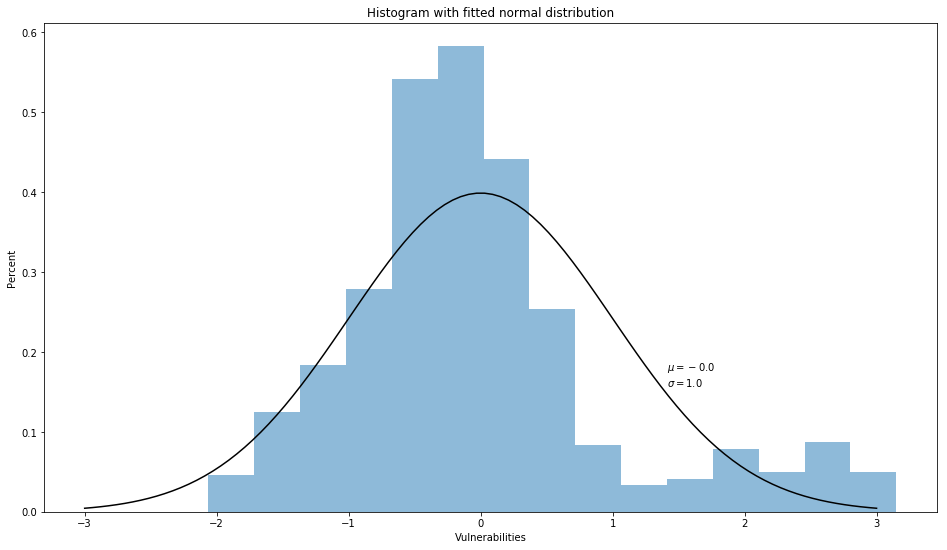

In [20]:
param = stats.norm.fit(X_s)
x = np.linspace(-3, 3, 100)
pdf_fitted = stats.norm.pdf(x, *param)
X_s.plot.hist(alpha=0.5, bins=15, normed=True, legend=None)
plt.text(x=np.min(df_pow), y=0.16, s=r"$\mu=%0.1f$" % param[0] + "\n" + r"$\sigma=%0.1f$" % param[1], color='k')

plt.xlabel('Vulnerabilities')
plt.ylabel('Percent')
plt.title("Histogram with fitted normal distribution")
plt.plot(x, pdf_fitted, color='k')
plt.show()

#### -Kernel Density Of Vulnerabilities from 2006-present

Text(0, 0.5, 'Percent')

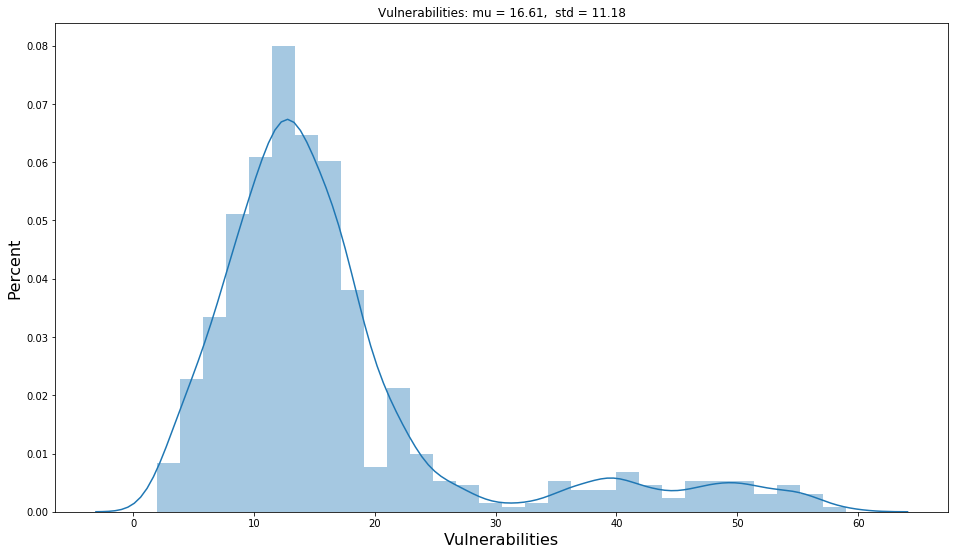

In [21]:
ax = sns.distplot(vulnsWeekCount['count'], bins=30, label='Vulnerabilities')
title = "Vulnerabilities: mu = %.2f,  std = %.2f" % (mu, std)
ax.set_title(title)
ax.set_xlabel("Vulnerabilities",fontsize=16)
ax.set_ylabel("Percent",fontsize=16)

### Measure of Releases Per Week

In [22]:
ReleasesWeekCount = pd.DataFrame()
ReleasesWeekCount['count'] = release_df['date'].value_counts().resample('w').apply('count')
ReleasesWeekCount.head()

,count
2005-09-18,1
2005-09-25,1
2005-10-02,0
2005-10-09,0
2005-10-16,0


#### -Plotting of New Releases by Week

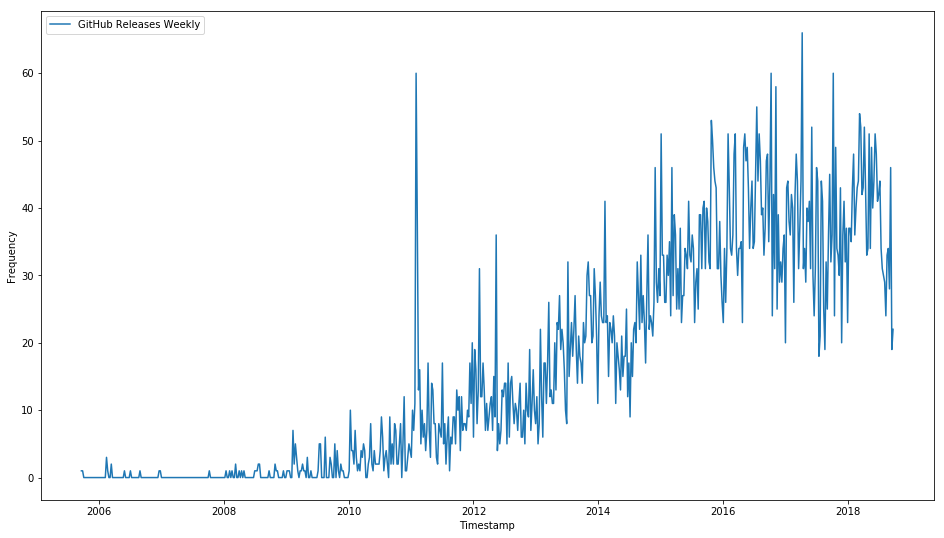

In [23]:
#ReleasesWeekCount.plot()
plt.plot(ReleasesWeekCount, label='GitHub Releases Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Basic Statistics on New Releases (Weekly)
       - Mean: 15.860294117647058
       - Median: 10.0
       - Variance: 266.04672745386813
       - Standard Deviation: 16.31093888940389

In [24]:
ReleasesWeekCount_mean = ReleasesWeekCount['count'].mean()
ReleasesWeekCount_med = ReleasesWeekCount['count'].median()
print( ReleasesWeekCount_mean )
print( ReleasesWeekCount_med )
ReleasesWeekCount_variance = stat.variance(ReleasesWeekCount['count'], ReleasesWeekCount_mean)
print(ReleasesWeekCount_variance)
ReleasesWeekCount_stdev = stat.stdev(ReleasesWeekCount['count'])
print(ReleasesWeekCount_stdev)

15.860294117647058
10.0
266.04672745386813
16.31093888940389


### Exploring Possible Relation Between New Releases and New Vulnerabilities
#### -Plotting of New Releases by Week & New Vulnerabilities by Week
    - Beginning to look at relationship between the two datasets.
    - Further Statistical analysis will be needed to determine if there is a relation.

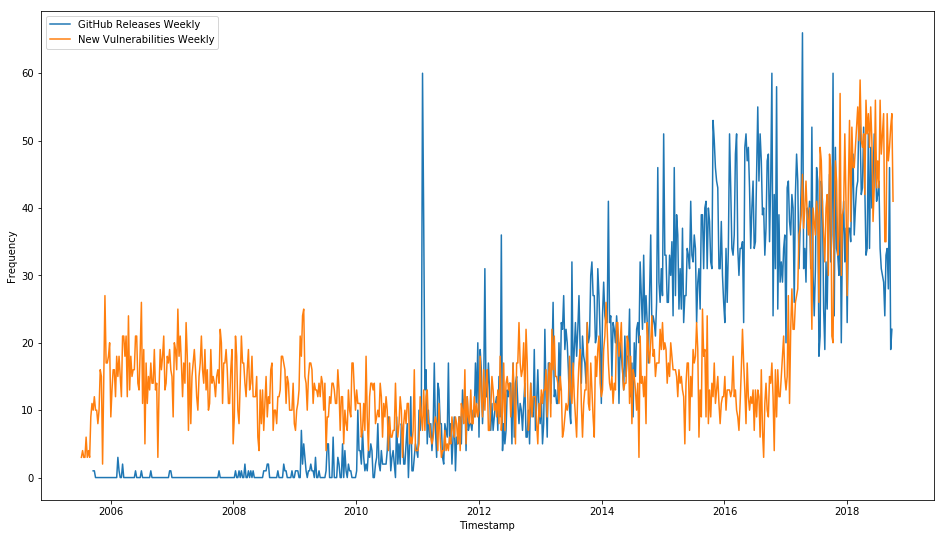

In [25]:
plt.plot(ReleasesWeekCount, label='GitHub Releases Weekly')
plt.plot(vulnsWeekCount, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Correlation between GitHub Releases and Spike in Vulnerabilities
    - As we being to look at the relationship, correlation is an obvious first step. However, with a correlation of 0.463581 the relationship doesn't seem to be too strong.
    - Again further analysis will be needed.

In [26]:
ReleasesWeekCount.corrwith(vulnsWeekCount)

count    0.463581
dtype: float64

#### -Trimming Vulnerabilities and Releases
    - In an effort to see if the correlation between the two increse as we look at smaller samples

In [27]:
def cleanByYear(df):
    df = df[(df['published_date'] >= '2017-01-07') & (df['published_date'] < '2018-10-01')]
    
    return df

In [28]:
Trimmedvulns = cleanByYear(vulns)
Trimmedvulns.head(10)

,cve_id,published_date,base_score
5,CVE-2001-0654,2017-05-11 14:29:00,NaN
6,CVE-2001-0655,2017-05-11 14:29:00,NaN
7,CVE-2001-0656,2017-05-11 14:29:00,NaN
8,CVE-2001-0657,2017-05-11 14:29:00,NaN
9,CVE-2001-0798,2017-05-11 14:29:00,NaN
10,CVE-2001-0802,2017-05-11 14:29:00,NaN
11,CVE-2001-0810,2017-05-11 14:29:00,NaN
12,CVE-2001-0811,2017-05-11 14:29:00,NaN
13,CVE-2001-0812,2017-05-11 14:29:00,NaN
14,CVE-2001-0813,2017-05-11 14:29:00,NaN


In [29]:
Trimmedvulns_by_week = pd.DataFrame()
Trimmedvulns_by_week['count'] = Trimmedvulns['published_date'].value_counts().resample('w').apply('count')

#### -Trimmed Version of Vulnerabilities Per Week (2017-2019)

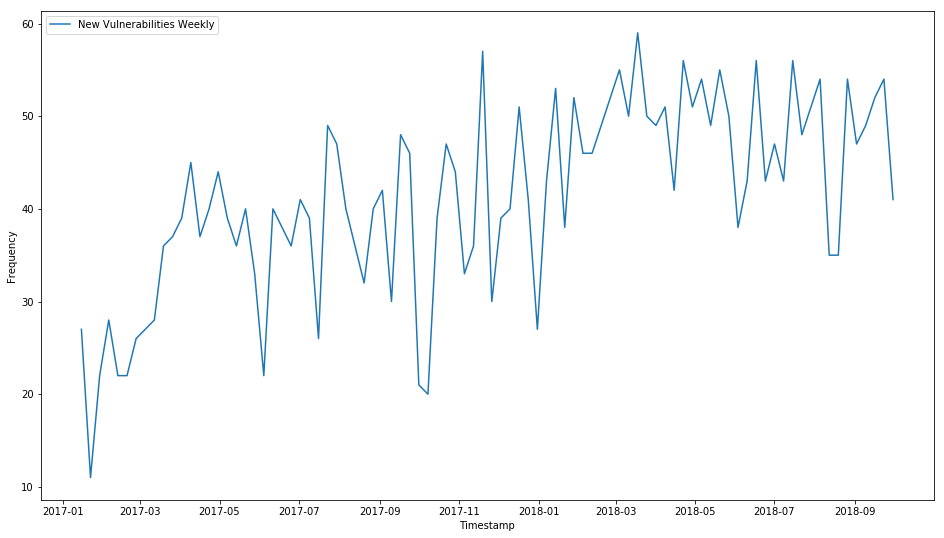

In [30]:
plt.plot(Trimmedvulns_by_week, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

In [31]:
def cleanByYearRelease(df):
    df = df[(df['date'] >= '2017-01-07') & (df['date'] < '2018-10-01')]
    
    return df

In [32]:
TrimmedReleases = cleanByYearRelease(release_df)
TrimmedReleases.head(10)

,id,date,name,comment,author
44,\xfeb880d80ee6e1d72f11cbef35a907ebf2d390c6,2017-02-24 15:13:50,\x352e332e30,release 5.3.0\n,6655756
45,\xed1d3005c82c47208917469bd41275c066cb61dd,2017-03-22 16:26:30,\x312e382e31,Official 1.8.1\n,4754174
46,\xf45e09c3429f37f86f10d14540cc08cb2e332593,2017-05-06 02:05:37,\x312e332e31,Add ability to download media metadata only\n,8164375
47,\x749abe0f87cb50011ea57f06e52177fd1257a8a4,2017-09-18 02:30:07,\x76322e342e302e302d302e352e726335,New release v2.4.0.0-0.5.rc5\n,418116
48,\x2820a13dc7c723270037a548631831ce7b3c5192,2017-11-17 21:04:59,\x302e31362e30,Version 0.16.0\n,74977
49,\x26a906dafc7b8661306ba1a3aec664ee73fbd3ef,2018-02-22 09:09:37,\x7631302e312e30,Release 10.1.0\n,378290
50,\x5a46c5d480a244e5343a352130b710e09f1c28df,2018-02-22 18:08:50,\x312e31342e3435,Tagging 1.14.45 release.\n,14715471
51,\x2578f1de595a7f8f23bf7639446e9c13d87e52a8,2018-03-29 22:19:37,\x312e31342e3637,Tagging 1.14.67 release.\n,14715471
52,\x2f3badf9f5dcaab5007d9fb804e3a1cda47745ef,2018-03-15 22:41:19,\x76312e332e32,Release 1.3.2\n,18415857
53,\x1eda71d73b7002c82e0a4a49b2d556505147bceb,2018-04-25 17:16:39,\x332e332e30,Picea mariana\n,458622


In [33]:
TrimmedReleases_by_week = pd.DataFrame()
TrimmedReleases_by_week['count'] = TrimmedReleases['date'].value_counts().resample('w').apply('count')

#### -Trimmed Version of Releases Per Week (2017-2019)

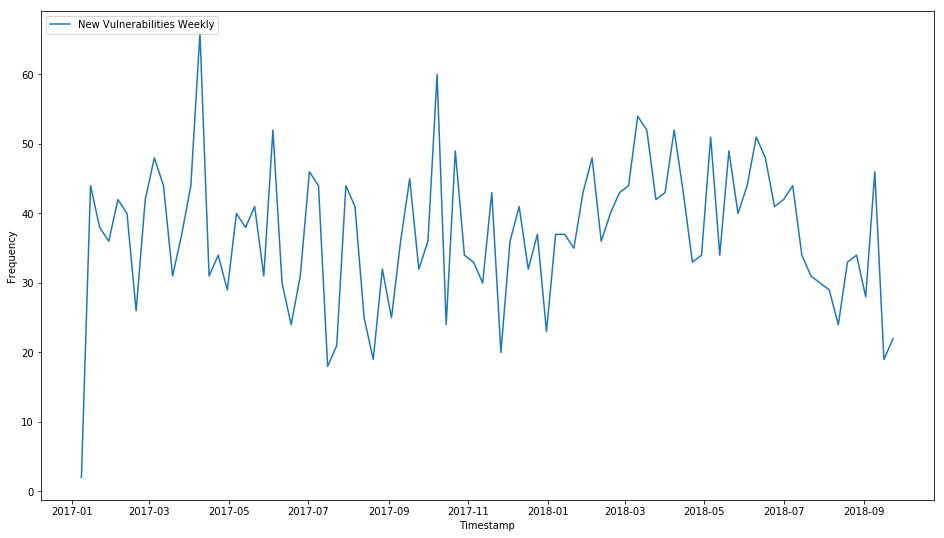

In [34]:
plt.plot(TrimmedReleases_by_week, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Trimmed Version of Releases and Vulnerabilities between 2017-2019

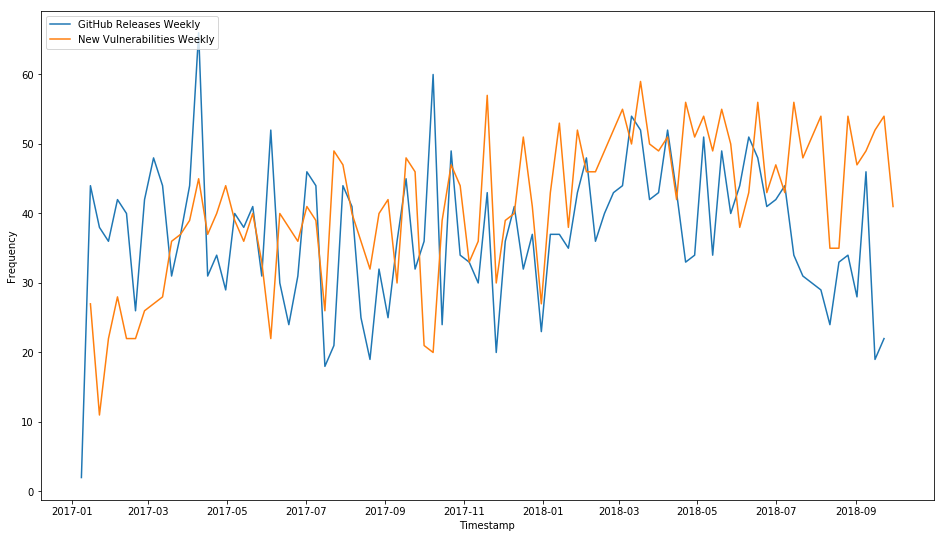

In [35]:
plt.plot(TrimmedReleases_by_week, label='GitHub Releases Weekly')
plt.plot(Trimmedvulns_by_week, label='New Vulnerabilities Weekly')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

#### -Relation Between Trimmed Vulnerabilities and Releases
    - In looking at the graph, I can depict a possible relationship between when a new release occurs and then a new vulnerability... For instance, if we are to look at when a spike in releases occur and then say within a two week or month period there is also a spike in vulnerabilities.
    - The correlation below does not help in supporting that idea. However, we have to take into account we are looking at a smaller set of data this time so and large variance will be represented in the correlation. 

In [36]:
TrimmedReleases_by_week.corrwith(Trimmedvulns_by_week)

count    0.122207
dtype: float64

#### -Hypothesis Testing
    - Null Hypothesis (H0):
        - An increase in releases does not cause an increase in vulnerabilities
    - Alternative Hypothesis (H1):
        - An increase in releases corresponds to an inccrease in new vulnerabilities

#### -Fitting Distribution to Trimmed Vulnerabilities Per Week

In [37]:
mu,std = norm.fit(Trimmedvulns_by_week['count'])

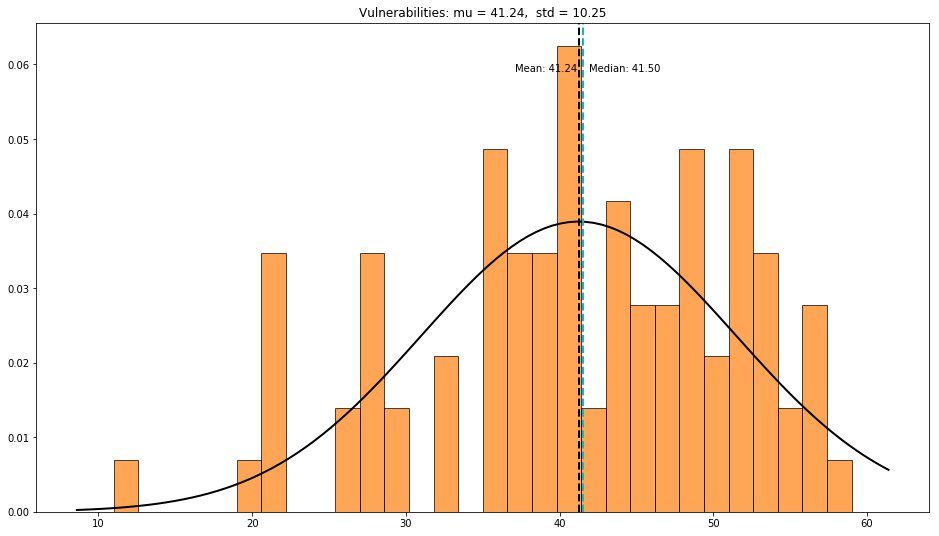

In [38]:
plt.hist(Trimmedvulns_by_week['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Vulnerabilities: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

#Calc Mean and Display
plt.axvline(Trimmedvulns_by_week['count'].mean(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(Trimmedvulns_by_week['count'].mean()*.9, max_ylim*0.9, 'Mean: {:.2f}'.format(Trimmedvulns_by_week['count'].mean()))

#Calc Median and Display
plt.axvline(Trimmedvulns_by_week['count'].median(), color='c', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(Trimmedvulns_by_week['count'].median()*1.01, max_ylim*0.9, 'Median: {:.2f}'.format(Trimmedvulns_by_week['count'].median()))

plt.show()

#### -Fitting Distribution to Trimmed Vulnerabilities Per Week Cont...
    - Trying to fit the histogram to a normal distribution so I can preform Hypothesis Testing
        - Failed to fit the histogram to a normal distribution...

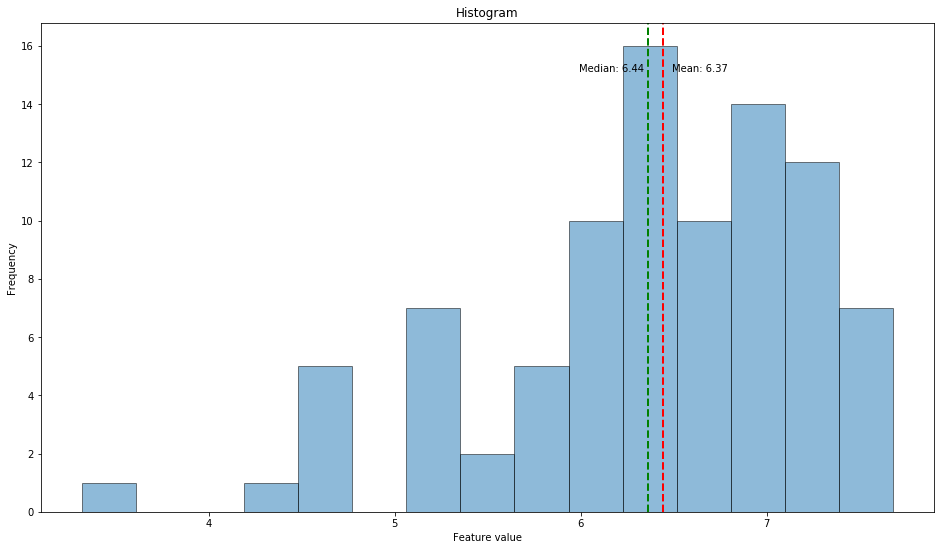

In [39]:
df_pow = Trimmedvulns_by_week.apply(np.sqrt)
df_pow.plot.hist(alpha=0.5, bins=15, color = "C0", legend=None, ec="black", linestyle='solid')
plt.xlabel("Feature value")
plt.title("Histogram")

#Calc Mean and Display
plt.axvline(df_pow['count'].mean(), color='g', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].mean()*1.02, max_ylim*0.9, 'Mean: {:.2f}'.format(df_pow['count'].mean()))

#Calc Median and Display
plt.axvline(df_pow['count'].median(), color='r', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pow['count'].median()*.93, max_ylim*0.9, 'Median: {:.2f}'.format(df_pow['count'].median()))

plt.show()

#### -Fitting Distribution to Trimmed Releases Per Week
    - Trimmed Releases fits a normal distribution. However trimmed Vulnerabilities doesn't fit.

In [40]:
mu,std = norm.fit(TrimmedReleases_by_week['count'])

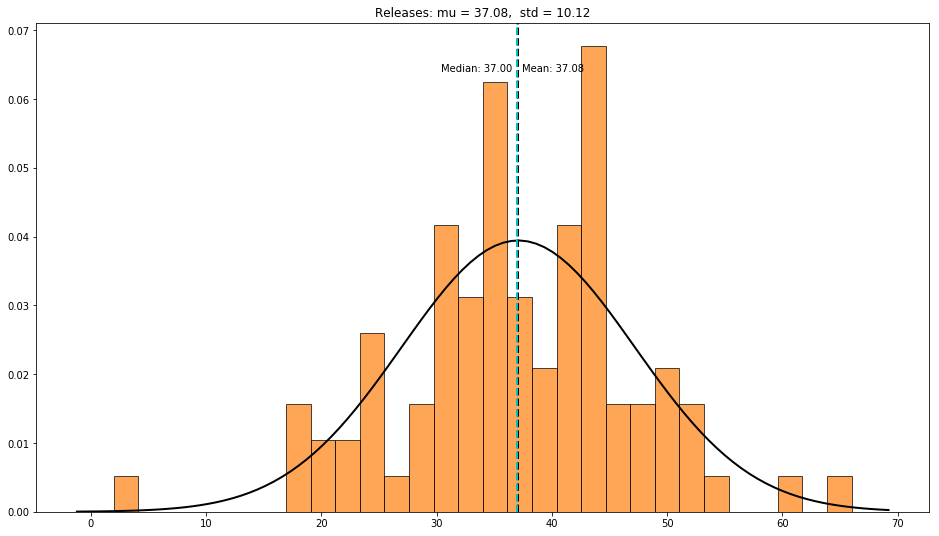

In [41]:
plt.hist(TrimmedReleases_by_week['count'].values, bins=30, density=True, linestyle='solid', color = "C1",alpha=0.7, ec="black")
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Releases: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

#Calc Mean and Display
plt.axvline(TrimmedReleases_by_week['count'].mean(), color='k', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(TrimmedReleases_by_week['count'].mean()*1.01, max_ylim*0.9, 'Mean: {:.2f}'.format(TrimmedReleases_by_week['count'].mean()))

#Calc Median and Display
plt.axvline(TrimmedReleases_by_week['count'].median(), color='c', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(TrimmedReleases_by_week['count'].median()*.82, max_ylim*0.9, 'Median: {:.2f}'.format(TrimmedReleases_by_week['count'].median()))

plt.show()